In [1]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

# Models and Instances

새로운 큐브를 생성한다면 위에서 했던 것처럼 한 점씩 직접 그려줄 수도 있지만, 좋은 방법이 아닙니다.

모델과 인스턴스의 입장에서 접근하는 것이 더욱 좋은 방향입니다.    
모델은 일반적인 큐브를 정의합니다.   
인스턴스는 큐브의 모델을 가지고 좀 더 구체적으로 디테일을 더해 인스턴스 화 하는것을 말합니다.   

In [2]:
class CubeModel:
    def __init__(self):
        self.verts = np.array([[ 1, 1, 1],
                      [-1, 1, 1],
                      [-1, -1, 1],
                      [ 1, -1, 1],
                      [ 1, 1, -1],
                      [-1, 1, -1],
                      [-1, -1, -1],
                      [ 1, -1, -1]])
        self.tries = np.array([[0, 1, 2],
                      [0, 2, 3],
                      [4, 0, 3],
                      [4, 3, 7],
                      [5, 4, 7],
                      [5, 7, 6],
                      [1, 5, 6],
                      [1, 6, 2],
                      [4, 5, 1],
                      [4, 1, 0],
                      [2, 6, 7],
                      [2, 7, 3]])

class InstModel:
    def __init__(self,
                model,
                position,
                rotation,
                scale): 
        self.model = model
        self.pos = position

# Model Transform

이번에는 각도(Rotation Angle), 크기 변환(scale), 위치 변환(Translation)을 각각 추가 하겠습니다.   
적용 순서는 다음과 같습니다.

Scale -> Rotation -> Translation



In [7]:
class CubeModel:
    def __init__(self):
        self.verts = np.array([[ 1, 1, 1],
                      [-1, 1, 1],
                      [-1, -1, 1],
                      [ 1, -1, 1],
                      [ 1, 1, -1],
                      [-1, 1, -1],
                      [-1, -1, -1],
                      [ 1, -1, -1]])
        self.tries = np.array([[0, 1, 2],
                      [0, 2, 3],
                      [4, 0, 3],
                      [4, 3, 7],
                      [5, 4, 7],
                      [5, 7, 6],
                      [1, 5, 6],
                      [1, 6, 2],
                      [4, 5, 1],
                      [4, 1, 0],
                      [2, 6, 7],
                      [2, 7, 3]])

class InstModel:
    def __init__(self,
                model,
                position,
                rotation,
                scale):
        self.model = model
        self.pos = position
        self.rot = rotation
        self.scale = scale

In [8]:
class Point:
    def __init__(self, x, y, h, color=[255,255,255]):
        self.x = x
        self.y = y
        self.h = h
        self.color = color
        
class Vertex:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        
class Camera:
    def __init__(self,
                 camera_position = [0,0,0],
                 viewport_size = 1,
                 projection_plane_z = 1
                 ):
        
        self.viewport_size = viewport_size
        self.projection_plane_z = projection_plane_z

In [9]:
class Canvas:
    def __init__(self,
                 width=600, 
                 height=600):
        self.width = width
        self.height = height
        
        self.img = np.zeros((width,height,3), dtype = np.uint8) + 255
        
    def put_pixel(self, x, y, color,line_width):
        x = self.width/2 + x
        y = self.height/2 - y -1
        if (x< 0 or x >= self.width or y < 0 or y >= self.height):
            return 
        R = int(color[0])
        G = int(color[1])
        B = int(color[2])
        cv2.line(self.img, (int(x), int(y)), (int(x), int(y)), (R,G,B),line_width)
        
class Scene:
    def __init__(self):
        self.instances = []
        
class Renderer:
    def __init__(self, camera, canvas, scene):
        self.camera = camera
        self.canvas = canvas
        self.scene = scene
        
        
    def draw_line(self, p0, p1, color, line_width=1):
        if np.abs(p0.x - p1.x) > abs(p0.y - p1.y):
            # line is horizontal-ish
            if p0.x > p1.x:
                p0, p1 = p1, p0
            
            ys = self.interpolate(p0.x,p0.y,p1.x,p1.y)

            for i in range(p1.x-p0.x+1):
                canvas.put_pixel(i+p0.x,ys[i],color,line_width)
                    
        else:
            # line is vertical-ish
                        # line is horizontal-ish
            if p0.y > p1.y:
                p0, p1 = p1, p0
            
            xs = self.interpolate(p0.y,p0.x,p1.y,p1.x)
            for i in range(p1.y-p0.y+1):
                canvas.put_pixel(xs[i], i+p0.y, color, line_width)
                
    
    def interpolate(self, i0, d0,i1, d1):
        if i0==i1:
            return [d0]
        else:
            values = []
            
            a = (d1-d0) / (i1 - i0)
            d = d0
            
            for i in range(i0, i1+1):
                values.append(d)
                d += a
            return values
        
    def draw_wire_triangle(self, p0, p1, p2, color, line_width):
        self.draw_line(p0, p1, color, line_width)
        self.draw_line(p1, p2, color, line_width)
        self.draw_line(p0, p2, color, line_width)
        
    def draw_filled_triangle(self, p0, p1, p2, color, line_width):
        # Sort the points so that y0 <= y1 <= y2
        if p1.y < p0.y:
            p1, p0 = p0, p1
        if p2.y < p0.y:
            p2, p0 = p0, p2
        if p2.y < p1.y:
            p1, p2 = p2, p1
        
        # Compute the x coordinates of the triangle edges
        x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
        x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
        x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
        
        # Concatenate the short sides
        x01.pop(-1)
        x012 = x01 + x12
        
        # Determine which is left and which is right
        m = math.floor(len(x012)/2)
        if x02[m] < x012[m]:
            x_left = x02
            x_right= x012
        else:
            x_left = x012
            x_right = x02
            
        # Draw the horizontal segments
        for y in range(p0.y,p2.y):
            x_left_value = math.floor(x_left[y-p0.y])
            x_right_value = math.floor(x_right[y-p0.y])
            for x in range(x_left_value, x_right_value+1):
                canvas.put_pixel(x,y,color,line_width)
                
    def draw_shaded_triangle(self, p0, p1, p2, color, line_width):
        # Sort the points so that y0 <= y1 <= y2
        if p1.y < p0.y:
            p1, p0 = p0, p1
        if p2.y < p0.y:
            p2, p0 = p0, p2
        if p2.y < p1.y:
            p1, p2 = p2, p1
            
        # Compute the x coordinates and h values of the triangle edges
        x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
        h01 = self.interpolate(p0.y, p0.h, p1.y, p1.h)
        
        x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
        h12 = self.interpolate(p1.y, p1.h, p2.y, p2.h)
        
        x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
        h02 = self.interpolate(p0.y, p0.h, p2.y, p2.h)
        
        # Concatenate the short sides
        x01.pop(-1)
        x012 = x01 + x12
        
        h01.pop(-1)
        h012 = h01 + h12
        
        # Determine which is left and which is right
        m = math.floor(len(x012)/2)
        if x02[m] < x012[m]:
            x_left = x02
            h_left = h02
            
            x_right= x012
            h_right = h012
        else:
            x_left = x012
            h_left = h012
            
            x_right = x02
            h_right = h02
            
        # Draw the horizontal segments
        for y in range(p0.y,p2.y):
            x_l= math.floor(x_left[y-p0.y])
            x_r = math.floor(x_right[y-p0.y])
            
            h_segment = self.interpolate(x_l, h_left[y - p0.y], x_r, h_right[y - p0.y])
            for x in range(x_l, x_r + 1):
                shaded_color = np.dot(color, h_segment[x - x_l])
                canvas.put_pixel(x,y,shaded_color,line_width)
                
    def viewport_to_canvas(self, x, y):
        p = Point(int(x * (canvas.width / camera.viewport_size)), int(y * (canvas.height / camera.viewport_size)), h =1.0)
        return p
    
    def project_vertex(self, v):
        d = camera.projection_plane_z
        return self.viewport_to_canvas(v[0] * d / v[2], v[1] * d / v[2])
    
    def render_scene(self):
        for inst in self.scene.instances:
            self.render_instance(inst)
        self.render()
        return 
    
    def render_instance(self, instance):
        projected = []
        model = instance.model
        
        for vert in model.verts:
            vert_wrld = self.apply_transform(vert, instance)
            projected.append(self.project_vertex(vert_wrld))
        for tri in model.tries:
            self.render_triangle(tri, projected)
        
        return
    
    def apply_transform(self, vert, instance: InstModel):
        cur_vert = vert
        new_vert = np.zeros((3))
        
        # scale 
        cur_vert = cur_vert * instance.scale
        
        # rotate in degrees
        angle = math.radians(instance.rot[0])
        new_vert[0] = cur_vert[0]
        new_vert[1] = cur_vert[1]*math.cos(angle) - cur_vert[2]*math.sin(angle)
        new_vert[2] = cur_vert[1]*math.sin(angle) + cur_vert[2]*math.cos(angle)
        cur_vert = new_vert.copy()
        
        angle = math.radians(instance.rot[1])
        new_vert[0] = cur_vert[2]*math.sin(angle) + cur_vert[0]*math.cos(angle)
        new_vert[1] = cur_vert[1]
        new_vert[2] = cur_vert[2]*math.cos(angle) - cur_vert[0]*math.sin(angle)
        cur_vert = new_vert.copy()
        
        angle = math.radians(instance.rot[2])
        new_vert[0] = cur_vert[0]*math.cos(angle) - cur_vert[1]*math.sin(angle)
        new_vert[1] = cur_vert[0]*math.sin(angle) + cur_vert[1]*math.cos(angle)
        new_vert[2] = cur_vert[2]
        cur_vert = new_vert.copy()

        # translate
        new_vert = new_vert + instance.pos
        
        return new_vert
        
    def render_triangle(self, triangle, vert_ls):
        self.draw_wire_triangle(vert_ls[triangle[0]],
                               vert_ls[triangle[1]],
                               vert_ls[triangle[2]],
                               np.array([0,0,0]),
                               2)
    def render(self):
        plt.imshow(self.canvas.img)
        return

In [10]:
camera = Camera(camera_position = [0,0,0], viewport_size = 1, projection_plane_z = 1)
canvas = Canvas(width=600, height=600)



cube_model = CubeModel()

# cube instances 
instances = []
instances.append(InstModel(cube_model,
                           np.array([0.5,2,10]),
                           np.array([40,30,10]),
                           np.array([1,2,1])
                          ))
instances.append(InstModel(cube_model,
                           np.array([1.5,-1.5,15]),
                           np.array([20,50,30]),
                           np.array([1,1,3])
                          ))

scene = Scene()
scene.instances = instances

renderer = Renderer(camera=camera, canvas=canvas, scene=scene)


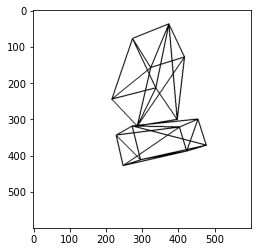

In [11]:
renderer.render_scene()